## Denoising Autoencoder on MNIST dataset
* This notebook will give you a very good understanding abou denoising autoencoders
* For more information: visit [here](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html)
* The entire notebook is in PyTorch

In [ ]:
# Importing packages that will be necessary for the project
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torch
import torch.optim as optim
from torch.autograd import Variable

In [ ]:
# Mounting the google drive to fetch data from it
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
#loading the mnist data
(x_train,y_train),(x_test,y_test)=mnist.load_data()
print("No of train datapoints:{}\nNo of test datapoints:{}".format(len(x_train),len(x_test)))

11493376/11490434 [==============================] - 0s 0us/step
No of train datapoints:60000
No of test datapoints:10000


In [ ]:
print(y_train[1]) # Checking labels

0


In [ ]:
#we add the noise 
"""
    'gauss'     Gaussian-distributed additive noise.
    'speckle'   out = image + n*image,where
                n is uniform noise with specified mean & variance.       
"""

def add_noise(img,noise_type="gaussian"):#input includes the type of the noise to be added and the input image
  
  row,col=28,28
  img=img.astype(np.float32)
  
  if noise_type=="gaussian":
    noise=np.random.normal(-5.9,5.9,img.shape) #input includes : mean, deviation, shape of the image and the function picks up a normal distribuition.
    noise=noise.reshape(row,col) # reshaping the noise 
    img=img+noise #adding the noise
    return img

  if noise_type=="speckle":
    noise=np.random.randn(row,col)
    noise=noise.reshape(row,col)
    img=img+img*noise
    return img

In [ ]:
#Now dividing the dataset into two parts and adding gaussian to one and speckle to another.
noises=["gaussian","speckle"]
noise_ct=0
noise_id=0 #id represnts which noise is being added, its 0 = gaussian and 1 = speckle
traindata=np.zeros((60000,28,28)) #revised training data



for idx in tqdm(range(len(x_train))): #for the first half we are using gaussian noise & for the second half speckle noise
  
  if noise_ct<(len(x_train)/2):
    noise_ct+=1
    traindata[idx]=add_noise(x_train[idx],noise_type=noises[noise_id])
    
  else:
    print("\n{} noise addition completed to images".format(noises[noise_id]))
    noise_id+=1
    noise_ct=0


print("\n{} noise addition completed to images".format(noises[noise_id])) 




noise_ct=0
noise_id=0
testdata=np.zeros((10000,28,28))

for idx in tqdm(range(len(x_test))): # Doing the same for the test set.
  
  if noise_ct<(len(x_test)/2):
    noise_ct+=1
    x=add_noise(x_test[idx],noise_type=noises[noise_id])
    testdata[idx]=x
    
  else:
    print("\n{} noise addition completed to images".format(noises[noise_id]))
    noise_id+=1
    noise_ct=0


print("\n{} noise addition completed to images".format(noises[noise_id]))

 53%|█████▎    | 32057/60000 [00:01<00:01, 19218.50it/s]


gaussian noise addition completed to images


 20%|██        | 2049/10000 [00:00<00:00, 20486.45it/s]


speckle noise addition completed to images


 78%|███████▊  | 7793/10000 [00:00<00:00, 19490.98it/s]


gaussian noise addition completed to images


100%|██████████| 10000/10000 [00:00<00:00, 18849.68it/s]


speckle noise addition completed to images


Text(0.5, 1.0, 'Noised Image')

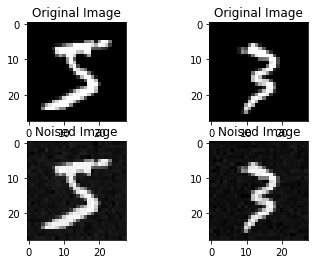

In [ ]:
f, axes=plt.subplots(2,2) #setting up 4 figures

#showing images with gaussian noise
axes[0,0].imshow(x_train[0],cmap="gray")#the original data
axes[0,0].set_title("Original Image")
axes[1,0].imshow(traindata[0],cmap='gray')#noised data
axes[1,0].set_title("Noised Image")

#showing images with speckle noise
axes[0,1].imshow(x_train[25000],cmap='gray')#original data
axes[0,1].set_title("Original Image")
axes[1,1].imshow(traindata[25000],cmap="gray")#noised data
axes[1,1].set_title("Noised Image")

In [ ]:
#creating a dataset builder i.e dataloaders
class noisedDataset(Dataset):
  
  def __init__(self,datasetnoised,datasetclean,labels,transform):
    self.noise=datasetnoised
    self.clean=datasetclean
    self.labels=labels
    self.transform=transform
  
  def __len__(self):
    return len(self.noise)
  
  def __getitem__(self,idx):
    xNoise=self.noise[idx]
    xClean=self.clean[idx]
    y=self.labels[idx]
    
    if self.transform != None:#just for using the totensor transform
      xNoise=self.transform(xNoise)
      xClean=self.transform(xClean)
      
    
    return (xNoise,xClean,y)

In [ ]:
#defining the totensor transforms
tsfms=transforms.Compose([
    transforms.ToTensor()
])

trainset=noisedDataset(traindata,x_train,y_train,tsfms)# the labels should not be corrupted because the model has to learn uniques features and denoise it.
testset=noisedDataset(testdata,x_test,y_test,tsfms)

In [ ]:
batch_size=32


#creating the dataloader
trainloader=DataLoader(trainset,batch_size=32,shuffle=True)
testloader=DataLoader(testset,batch_size=1,shuffle=True)

In [ ]:
#building our ae model:
class denoising_model(nn.Module):
  def __init__(self):
    super(denoising_model,self).__init__()
    self.encoder=nn.Sequential(
                  nn.Linear(28*28,256),#decreasing the features in the encoder
                  nn.ReLU(True),
                  nn.Linear(256,128),
                  nn.ReLU(True),
                  nn.Linear(128,64),
                  nn.ReLU(True)
        
                  )
    
    self.decoder=nn.Sequential(
                  nn.Linear(64,128),#increasing the number of features
                  nn.ReLU(True),
                  nn.Linear(128,256),
                  nn.ReLU(True),
                  nn.Linear(256,28*28),
                  nn.Sigmoid(),
                  )
    
 
  def forward(self,x):
    x=self.encoder(x)#first the encoder
    x=self.decoder(x)#then the decoder to reconstruct the original input.
    
    return x

In [ ]:
#this is the training code, can be modified according to requirements
#setting the device
if torch.cuda.is_available()==True:
  device="cuda:0"
else:
  device ="cpu"

  
model=denoising_model().to(device)
criterion=nn.MSELoss()
optimizer=optim.SGD(model.parameters(),lr=0.01,weight_decay=1e-5)

#setting the number of epochs
epochs=120
l=len(trainloader)
losslist=list()
epochloss=0
running_loss=0
for epoch in range(epochs):
  
  print("Entering Epoch: ",epoch)
  for dirty,clean,label in tqdm((trainloader)):
    
    
    dirty=dirty.view(dirty.size(0),-1).type(torch.FloatTensor)
    clean=clean.view(clean.size(0),-1).type(torch.FloatTensor)
    dirty,clean=dirty.to(device),clean.to(device)
    
    
    
    #-----------------Forward Pass----------------------
    output=model(dirty)
    loss=criterion(output,clean)
    #-----------------Backward Pass---------------------
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    running_loss+=loss.item()
    epochloss+=loss.item()
  #-----------------Log-------------------------------
  losslist.append(running_loss/l)
  running_loss=0
  print("======> epoch: {}/{}, Loss:{}".format(epoch,epochs,loss.item()))

  0%|          | 0/1875 [00:00<?, ?it/s]

Entering Epoch:  0


  1%|          | 19/1875 [00:00<00:10, 181.55it/s]

======> epoch: 0/120, Loss:0.07655805349349976
Entering Epoch:  1


  1%|          | 16/1875 [00:00<00:12, 151.96it/s]

======> epoch: 1/120, Loss:0.06866743415594101
Entering Epoch:  2


  1%|          | 16/1875 [00:00<00:12, 154.73it/s]

======> epoch: 2/120, Loss:0.0734129250049591
Entering Epoch:  3


  1%|          | 16/1875 [00:00<00:11, 158.49it/s]

======> epoch: 3/120, Loss:0.06309104710817337
Entering Epoch:  4


  1%|          | 14/1875 [00:00<00:14, 131.77it/s]

======> epoch: 4/120, Loss:0.07221430540084839
Entering Epoch:  5


  1%|          | 17/1875 [00:00<00:11, 165.56it/s]

======> epoch: 5/120, Loss:0.060313016176223755
Entering Epoch:  6


  1%|          | 15/1875 [00:00<00:12, 143.50it/s]

======> epoch: 6/120, Loss:0.0545106865465641
Entering Epoch:  7


  1%|          | 15/1875 [00:00<00:12, 145.40it/s]

======> epoch: 7/120, Loss:0.05784629285335541
Entering Epoch:  8


  1%|          | 16/1875 [00:00<00:11, 157.58it/s]

======> epoch: 8/120, Loss:0.05313542112708092
Entering Epoch:  9


  1%|          | 15/1875 [00:00<00:12, 147.76it/s]

======> epoch: 9/120, Loss:0.0563567578792572
Entering Epoch:  10


  1%|          | 17/1875 [00:00<00:11, 166.63it/s]

======> epoch: 10/120, Loss:0.05097239464521408
Entering Epoch:  11


  1%|          | 14/1875 [00:00<00:13, 139.44it/s]

======> epoch: 11/120, Loss:0.04794689267873764
Entering Epoch:  12


  1%|          | 17/1875 [00:00<00:11, 161.49it/s]

======> epoch: 12/120, Loss:0.048914652317762375
Entering Epoch:  13


  1%|          | 15/1875 [00:00<00:12, 144.82it/s]

======> epoch: 13/120, Loss:0.042824044823646545
Entering Epoch:  14


  1%|          | 15/1875 [00:00<00:13, 142.62it/s]

======> epoch: 14/120, Loss:0.04233626276254654
Entering Epoch:  15


  1%|          | 16/1875 [00:00<00:12, 151.46it/s]

======> epoch: 15/120, Loss:0.04042591527104378
Entering Epoch:  16


  1%|          | 12/1875 [00:00<00:16, 116.25it/s]

======> epoch: 16/120, Loss:0.046115558594465256
Entering Epoch:  17


  1%|          | 14/1875 [00:00<00:13, 137.81it/s]

======> epoch: 17/120, Loss:0.03918847441673279
Entering Epoch:  18


  1%|          | 14/1875 [00:00<00:13, 138.86it/s]

======> epoch: 18/120, Loss:0.03933500871062279
Entering Epoch:  19


  1%|          | 14/1875 [00:00<00:14, 132.26it/s]

======> epoch: 19/120, Loss:0.04311181232333183
Entering Epoch:  20


  1%|          | 14/1875 [00:00<00:13, 134.09it/s]

======> epoch: 20/120, Loss:0.038082387298345566
Entering Epoch:  21


  1%|          | 14/1875 [00:00<00:13, 136.07it/s]

======> epoch: 21/120, Loss:0.03792873024940491
Entering Epoch:  22


  1%|          | 12/1875 [00:00<00:16, 115.72it/s]

======> epoch: 22/120, Loss:0.03787040337920189
Entering Epoch:  23


  1%|          | 14/1875 [00:00<00:13, 134.82it/s]

======> epoch: 23/120, Loss:0.04096442833542824
Entering Epoch:  24


  1%|          | 13/1875 [00:00<00:14, 127.91it/s]

======> epoch: 24/120, Loss:0.03876926749944687
Entering Epoch:  25


  1%|          | 15/1875 [00:00<00:12, 143.95it/s]

======> epoch: 25/120, Loss:0.035967059433460236
Entering Epoch:  26


  1%|          | 14/1875 [00:00<00:14, 131.64it/s]

======> epoch: 26/120, Loss:0.03835727646946907
Entering Epoch:  27


  1%|          | 14/1875 [00:00<00:13, 139.72it/s]

======> epoch: 27/120, Loss:0.03594820201396942
Entering Epoch:  28


  1%|          | 13/1875 [00:00<00:14, 127.89it/s]

======> epoch: 28/120, Loss:0.036595940589904785
Entering Epoch:  29


  1%|          | 13/1875 [00:00<00:14, 125.81it/s]

======> epoch: 29/120, Loss:0.039768513292074203
Entering Epoch:  30


  1%|          | 13/1875 [00:00<00:14, 126.92it/s]

======> epoch: 30/120, Loss:0.030412830412387848
Entering Epoch:  31


  1%|          | 13/1875 [00:00<00:14, 126.66it/s]

======> epoch: 31/120, Loss:0.033342208713293076
Entering Epoch:  32


  1%|          | 10/1875 [00:00<00:19, 95.45it/s]

======> epoch: 32/120, Loss:0.03679276630282402
Entering Epoch:  33


  1%|          | 14/1875 [00:00<00:13, 133.21it/s]

======> epoch: 33/120, Loss:0.031338147819042206
Entering Epoch:  34


  1%|          | 13/1875 [00:00<00:14, 126.77it/s]

======> epoch: 34/120, Loss:0.03350548446178436
Entering Epoch:  35


  1%|          | 13/1875 [00:00<00:14, 124.87it/s]

======> epoch: 35/120, Loss:0.027809547260403633
Entering Epoch:  36


  1%|          | 12/1875 [00:00<00:15, 118.24it/s]

======> epoch: 36/120, Loss:0.035081349313259125
Entering Epoch:  37


  1%|          | 14/1875 [00:00<00:13, 138.19it/s]

======> epoch: 37/120, Loss:0.03334449976682663
Entering Epoch:  38


  1%|          | 14/1875 [00:00<00:13, 134.15it/s]

======> epoch: 38/120, Loss:0.032198466360569
Entering Epoch:  39


  1%|          | 14/1875 [00:00<00:13, 133.39it/s]

======> epoch: 39/120, Loss:0.03148077800869942
Entering Epoch:  40


  1%|          | 12/1875 [00:00<00:15, 119.90it/s]

======> epoch: 40/120, Loss:0.03296917676925659
Entering Epoch:  41


  1%|          | 13/1875 [00:00<00:14, 125.30it/s]

======> epoch: 41/120, Loss:0.033074751496315
Entering Epoch:  42


  1%|          | 12/1875 [00:00<00:15, 118.42it/s]

======> epoch: 42/120, Loss:0.026806367561221123
Entering Epoch:  43


  1%|          | 13/1875 [00:00<00:14, 129.79it/s]

======> epoch: 43/120, Loss:0.030488045886158943
Entering Epoch:  44


  1%|          | 15/1875 [00:00<00:12, 143.97it/s]

======> epoch: 44/120, Loss:0.03101782128214836
Entering Epoch:  45


  1%|          | 14/1875 [00:00<00:14, 132.17it/s]

======> epoch: 45/120, Loss:0.03301885351538658
Entering Epoch:  46


  1%|          | 13/1875 [00:00<00:14, 124.51it/s]

======> epoch: 46/120, Loss:0.02984663099050522
Entering Epoch:  47


  1%|          | 13/1875 [00:00<00:15, 120.40it/s]

======> epoch: 47/120, Loss:0.03226644545793533
Entering Epoch:  48


  1%|          | 15/1875 [00:00<00:12, 146.41it/s]

======> epoch: 48/120, Loss:0.026942763477563858
Entering Epoch:  49


  1%|          | 13/1875 [00:00<00:14, 129.45it/s]

======> epoch: 49/120, Loss:0.028122566640377045
Entering Epoch:  50


  1%|          | 14/1875 [00:00<00:13, 133.12it/s]

======> epoch: 50/120, Loss:0.032489486038684845
Entering Epoch:  51


  1%|          | 12/1875 [00:00<00:15, 118.52it/s]

======> epoch: 51/120, Loss:0.027188517153263092
Entering Epoch:  52


  1%|          | 13/1875 [00:00<00:14, 126.93it/s]

======> epoch: 52/120, Loss:0.026840534061193466
Entering Epoch:  53


  1%|          | 14/1875 [00:00<00:13, 133.50it/s]

======> epoch: 53/120, Loss:0.02796582132577896
Entering Epoch:  54


  1%|          | 12/1875 [00:00<00:15, 119.88it/s]

======> epoch: 54/120, Loss:0.026841385290026665
Entering Epoch:  55


  1%|          | 14/1875 [00:00<00:13, 135.42it/s]

======> epoch: 55/120, Loss:0.030861621722579002
Entering Epoch:  56


  1%|          | 13/1875 [00:00<00:14, 127.03it/s]

======> epoch: 56/120, Loss:0.03170158341526985
Entering Epoch:  57


  1%|          | 14/1875 [00:00<00:14, 132.41it/s]

======> epoch: 57/120, Loss:0.027990087866783142
Entering Epoch:  58


  1%|          | 12/1875 [00:00<00:16, 114.78it/s]

======> epoch: 58/120, Loss:0.02624969184398651
Entering Epoch:  59


  1%|          | 13/1875 [00:00<00:15, 122.14it/s]

======> epoch: 59/120, Loss:0.03171001374721527
Entering Epoch:  60


  1%|          | 13/1875 [00:00<00:14, 126.78it/s]

======> epoch: 60/120, Loss:0.029582856222987175
Entering Epoch:  61


  1%|          | 13/1875 [00:00<00:14, 128.13it/s]

======> epoch: 61/120, Loss:0.030450789257884026
Entering Epoch:  62


  1%|          | 13/1875 [00:00<00:14, 124.90it/s]

======> epoch: 62/120, Loss:0.029638638719916344
Entering Epoch:  63


  1%|          | 13/1875 [00:00<00:15, 122.19it/s]

======> epoch: 63/120, Loss:0.02794043906033039
Entering Epoch:  64


  1%|          | 14/1875 [00:00<00:13, 133.44it/s]

======> epoch: 64/120, Loss:0.026989245787262917
Entering Epoch:  65


  1%|          | 13/1875 [00:00<00:14, 129.96it/s]

======> epoch: 65/120, Loss:0.027833761647343636
Entering Epoch:  66


  1%|          | 14/1875 [00:00<00:13, 135.79it/s]

======> epoch: 66/120, Loss:0.030930863693356514
Entering Epoch:  67


  1%|          | 14/1875 [00:00<00:13, 134.96it/s]

======> epoch: 67/120, Loss:0.02531440369784832
Entering Epoch:  68


  1%|          | 13/1875 [00:00<00:14, 127.41it/s]

======> epoch: 68/120, Loss:0.02740127220749855
Entering Epoch:  69


  1%|          | 13/1875 [00:00<00:15, 122.35it/s]

======> epoch: 69/120, Loss:0.027579134330153465
Entering Epoch:  70


  1%|          | 11/1875 [00:00<00:18, 103.19it/s]

======> epoch: 70/120, Loss:0.027055896818637848
Entering Epoch:  71


  1%|          | 13/1875 [00:00<00:14, 124.43it/s]

======> epoch: 71/120, Loss:0.02910572662949562
Entering Epoch:  72


  1%|          | 13/1875 [00:00<00:14, 125.79it/s]

======> epoch: 72/120, Loss:0.029532991349697113
Entering Epoch:  73


  1%|          | 13/1875 [00:00<00:14, 125.52it/s]

======> epoch: 73/120, Loss:0.029182277619838715
Entering Epoch:  74


  1%|          | 13/1875 [00:00<00:14, 128.01it/s]

======> epoch: 74/120, Loss:0.026421111077070236
Entering Epoch:  75


  1%|          | 13/1875 [00:00<00:14, 126.09it/s]

======> epoch: 75/120, Loss:0.02665863186120987
Entering Epoch:  76


  1%|          | 13/1875 [00:00<00:14, 125.76it/s]

======> epoch: 76/120, Loss:0.02383933961391449
Entering Epoch:  77


  1%|          | 12/1875 [00:00<00:16, 111.16it/s]

======> epoch: 77/120, Loss:0.025645989924669266
Entering Epoch:  78


  1%|          | 14/1875 [00:00<00:13, 134.93it/s]

======> epoch: 78/120, Loss:0.026404602453112602
Entering Epoch:  79


  1%|          | 14/1875 [00:00<00:13, 136.80it/s]

======> epoch: 79/120, Loss:0.026165591552853584
Entering Epoch:  80


  1%|          | 13/1875 [00:00<00:15, 122.31it/s]

======> epoch: 80/120, Loss:0.028156444430351257
Entering Epoch:  81


  1%|          | 14/1875 [00:00<00:14, 132.58it/s]

======> epoch: 81/120, Loss:0.02646087110042572
Entering Epoch:  82


  1%|          | 14/1875 [00:00<00:13, 139.55it/s]

======> epoch: 82/120, Loss:0.024330152198672295
Entering Epoch:  83


  1%|          | 14/1875 [00:00<00:13, 135.96it/s]

======> epoch: 83/120, Loss:0.025489648804068565
Entering Epoch:  84


  1%|          | 13/1875 [00:00<00:14, 129.89it/s]

======> epoch: 84/120, Loss:0.02928599715232849
Entering Epoch:  85


  1%|          | 13/1875 [00:00<00:15, 122.54it/s]

======> epoch: 85/120, Loss:0.024828536435961723
Entering Epoch:  86


  1%|          | 15/1875 [00:00<00:13, 142.14it/s]

======> epoch: 86/120, Loss:0.02515496127307415
Entering Epoch:  87


  1%|          | 14/1875 [00:00<00:14, 130.82it/s]

======> epoch: 87/120, Loss:0.029436606913805008
Entering Epoch:  88


  1%|          | 16/1875 [00:00<00:12, 151.10it/s]

======> epoch: 88/120, Loss:0.025549031794071198
Entering Epoch:  89


  1%|          | 14/1875 [00:00<00:13, 136.03it/s]

======> epoch: 89/120, Loss:0.025611326098442078
Entering Epoch:  90


  1%|          | 14/1875 [00:00<00:13, 137.77it/s]

======> epoch: 90/120, Loss:0.021191325038671494
Entering Epoch:  91


  1%|          | 15/1875 [00:00<00:13, 142.47it/s]

======> epoch: 91/120, Loss:0.027545863762497902
Entering Epoch:  92


  1%|          | 14/1875 [00:00<00:13, 139.11it/s]

======> epoch: 92/120, Loss:0.026861516758799553
Entering Epoch:  93


  1%|          | 15/1875 [00:00<00:12, 143.28it/s]

======> epoch: 93/120, Loss:0.02385450340807438
Entering Epoch:  94


  1%|          | 13/1875 [00:00<00:15, 122.30it/s]

======> epoch: 94/120, Loss:0.022495916113257408
Entering Epoch:  95


  1%|          | 14/1875 [00:00<00:13, 139.96it/s]

======> epoch: 95/120, Loss:0.02676970884203911
Entering Epoch:  96


  1%|          | 13/1875 [00:00<00:14, 129.75it/s]

======> epoch: 96/120, Loss:0.025168895721435547
Entering Epoch:  97


  1%|          | 14/1875 [00:00<00:13, 139.87it/s]

======> epoch: 97/120, Loss:0.021699000149965286
Entering Epoch:  98


  1%|          | 12/1875 [00:00<00:16, 115.37it/s]

======> epoch: 98/120, Loss:0.02692207507789135
Entering Epoch:  99


  1%|          | 14/1875 [00:00<00:13, 132.97it/s]

======> epoch: 99/120, Loss:0.025918878614902496
Entering Epoch:  100


  1%|          | 15/1875 [00:00<00:13, 142.47it/s]

======> epoch: 100/120, Loss:0.02890481799840927
Entering Epoch:  101


  1%|          | 13/1875 [00:00<00:14, 127.57it/s]

======> epoch: 101/120, Loss:0.027479737997055054
Entering Epoch:  102


  1%|          | 15/1875 [00:00<00:12, 143.94it/s]

======> epoch: 102/120, Loss:0.0239412859082222
Entering Epoch:  103


  1%|          | 15/1875 [00:00<00:12, 147.15it/s]

======> epoch: 103/120, Loss:0.02598128281533718
Entering Epoch:  104


  1%|          | 15/1875 [00:00<00:13, 141.86it/s]

======> epoch: 104/120, Loss:0.025640787556767464
Entering Epoch:  105


  1%|          | 14/1875 [00:00<00:13, 133.60it/s]

======> epoch: 105/120, Loss:0.023611973971128464
Entering Epoch:  106


  1%|          | 14/1875 [00:00<00:14, 129.80it/s]

======> epoch: 106/120, Loss:0.026524612680077553
Entering Epoch:  107


  1%|          | 14/1875 [00:00<00:13, 137.59it/s]

======> epoch: 107/120, Loss:0.024700744077563286
Entering Epoch:  108


  1%|          | 14/1875 [00:00<00:13, 133.04it/s]

======> epoch: 108/120, Loss:0.02533978782594204
Entering Epoch:  109


  1%|          | 14/1875 [00:00<00:14, 132.57it/s]

======> epoch: 109/120, Loss:0.024778911843895912
Entering Epoch:  110


  1%|          | 13/1875 [00:00<00:14, 129.55it/s]

======> epoch: 110/120, Loss:0.02427179552614689
Entering Epoch:  111


  1%|          | 15/1875 [00:00<00:13, 142.98it/s]

======> epoch: 111/120, Loss:0.02724272385239601
Entering Epoch:  112


  1%|          | 15/1875 [00:00<00:12, 146.89it/s]

======> epoch: 112/120, Loss:0.025939742103219032
Entering Epoch:  113


  1%|          | 14/1875 [00:00<00:13, 138.99it/s]

======> epoch: 113/120, Loss:0.025211431086063385
Entering Epoch:  114


  1%|          | 16/1875 [00:00<00:12, 154.32it/s]

======> epoch: 114/120, Loss:0.023597819730639458
Entering Epoch:  115


  1%|          | 14/1875 [00:00<00:13, 139.95it/s]

======> epoch: 115/120, Loss:0.022066619247198105
Entering Epoch:  116


  1%|          | 16/1875 [00:00<00:11, 156.35it/s]

======> epoch: 116/120, Loss:0.02377207949757576
Entering Epoch:  117


  1%|          | 14/1875 [00:00<00:13, 137.90it/s]

======> epoch: 117/120, Loss:0.024058736860752106
Entering Epoch:  118


  1%|          | 13/1875 [00:00<00:14, 126.31it/s]

======> epoch: 118/120, Loss:0.027325334027409554
Entering Epoch:  119


100%|██████████| 1875/1875 [00:12<00:00, 152.38it/s]

======> epoch: 119/120, Loss:0.025885485112667084


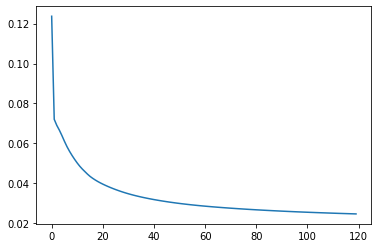

In [ ]:
#plotting the loss curve
plt.plot(range(len(losslist)),losslist)

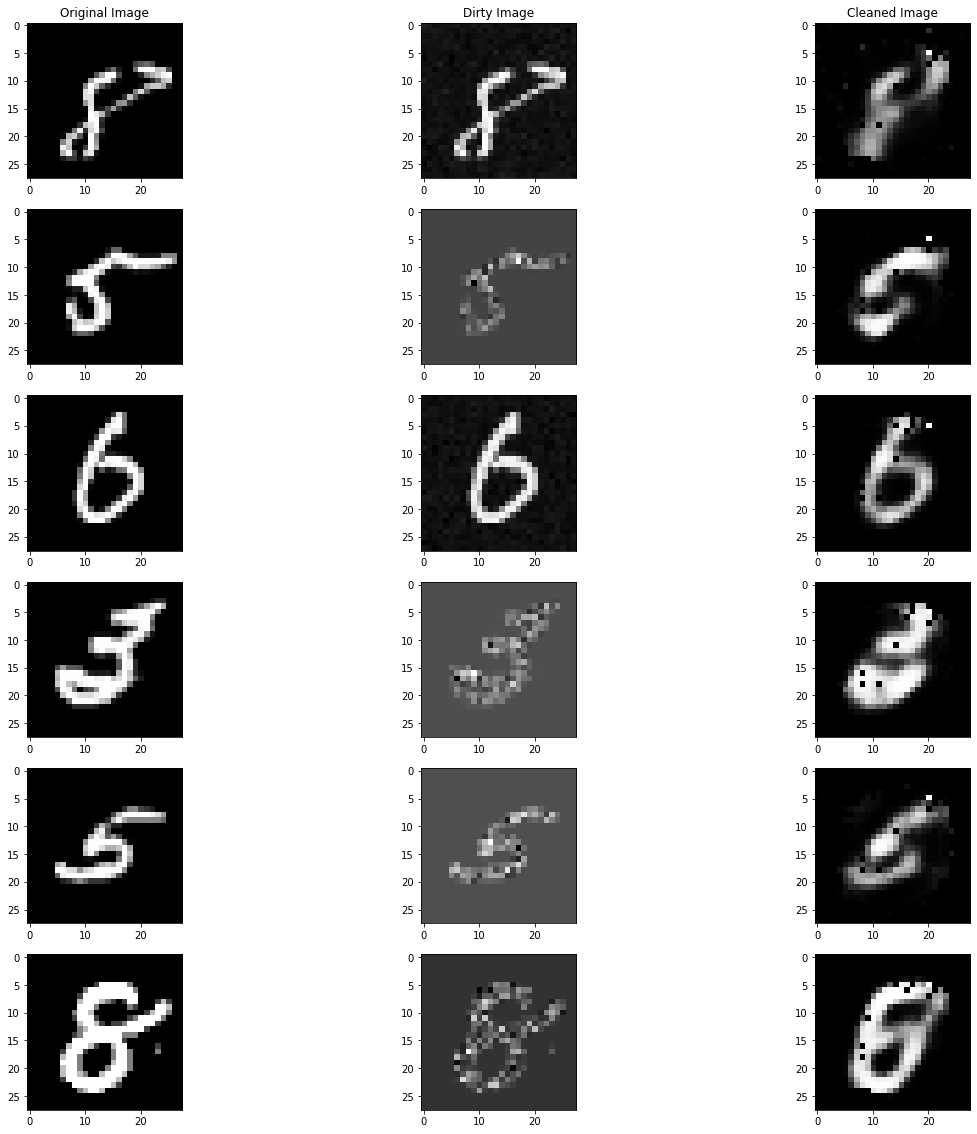

In [ ]:
"""Here, we try to visualize some of the results.
  We randomly generate 6 numbers in between 1 and 10k , run them through the model,
  and show the results with comparisons
  
 """

f,axes= plt.subplots(6,3,figsize=(20,20))
axes[0,0].set_title("Original Image")
axes[0,1].set_title("Dirty Image")
axes[0,2].set_title("Cleaned Image")

test_imgs=np.random.randint(0,10000,size=6)
for idx in range((6)):
  dirty=testset[test_imgs[idx]][0]
  clean=testset[test_imgs[idx]][1]
  label=testset[test_imgs[idx]][2]
  dirty=dirty.view(dirty.size(0),-1).type(torch.FloatTensor)
  dirty=dirty.to(device)
  output=model(dirty)
  
  output=output.view(1,28,28)
  output=output.permute(1,2,0).squeeze(2)
  output=output.detach().cpu().numpy()
  
  dirty=dirty.view(1,28,28)
  dirty=dirty.permute(1,2,0).squeeze(2)
  dirty=dirty.detach().cpu().numpy()
  
  clean=clean.permute(1,2,0).squeeze(2)
  clean=clean.detach().cpu().numpy()
  
  axes[idx,0].imshow(clean,cmap="gray")
  axes[idx,1].imshow(dirty,cmap="gray")
  axes[idx,2].imshow(output,cmap="gray")